# The Dataset

We used this dataset for our miniproject: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

The dataset contains 6 classes of images: `building`, `forest`, `glacier`, `mountain`, `sea`, and `street`. We decided to delete the class `street` and it's corresponding pictures to simplify the learning process. The images are divided into folders with their respective labels. We used the image_dataset_from_directory method of Keras to convert the images into a TensorFlow dataset object for training.

## Importing the Data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
training_img_path = "./dataset/seg_train/seg_train/"

img_size = 50
batch_size = 32
seed = 42

train_ds = keras.utils.image_dataset_from_directory(
    training_img_path,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    training_img_path,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 11652 files belonging to 5 classes.
Using 9322 files for training.
Found 11652 files belonging to 5 classes.
Using 2330 files for validation.


Let's see the first few images of the training dataset. Here, we'll define a function that we'll use again later in the notebook.

To adhere to the requrement of not having too many parameters in our model (after the feature map is flattened), we downscaled the images from $150 \times 150px$ to $50 \times 50px$.

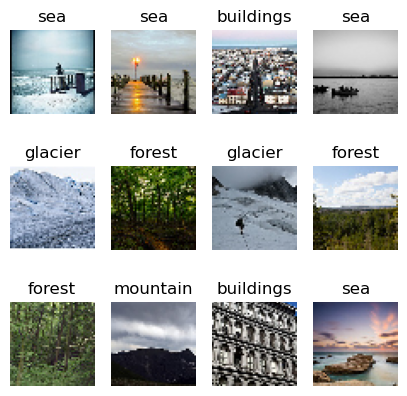

In [21]:
def show_dataset():
  plt.figure(figsize=(5, 5))
  sample_images = []
  for images, labels in train_ds.take(1):
    for i in range(12):
      ax = plt.subplot(3, 4, i + 1)
      sample_images.append((images[i], labels[i]))
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(train_ds.class_names[labels[i]])
      plt.axis("off")

show_dataset()

# Underfitting Model
We will create a model that is too simple and won't describe the data accurately enough.

## Building the Model
We start with a convolutional layer that'll import/rescale the images to `img_size`, using the ReLU activation function (for all the convolution and dense layers).

TODO: Should we use a saturating activation function like tanh instead of a non-saturating one like ReLU?

Then, run a kernel of $3 \times 3$ over each image 16 times. `padding=same` is referring to the padding of the image (needed because of the kernel) being filled with zeros.

Following that is another convolution layer and max pooling layer. Next, the image will be flattened into a vector, ready to be fed to the following dense layer. In this case, we first wanted to apply dropout to the layer, but we ended up just halfing the amount of nodes of that layer. Why? We learned that the difference between applying `dropout(0.5)` and halving the nodes of the layer is that dropout randomly drops out nodes during each training iteration, which means that **different** nodes will be dropped out in each iteration. This allows the network to learn more robust and generalizable representations of the data, as it is forced to rely on a subset of nodes in each iteration, which prevents overfitting. While halving the nodes reduces the number of nodes in the layer permanently, which means that the network has less capacity to learn and represent complex patterns in the data. This then leads to underfitting, where the model is not able to capture the important features in the data. Which is exactly what we want.

The last dense layer represents the output layer, having a shared softmax activation layer to determine the probabilities of the 5 different classes.

This task was interesting because we initially built a model that was too simple, even for underfitting. After the second epoch, it couldn't learn any more information because it simply was not complex enough. As a result, the accuracy stalled at around 0.25 and stayed the same for all the remaining epochs. We were not happy with that, so we now created a model that can actually improve with each epoch while still underfitting.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(8, (3,3), input_shape=(img_size,img_size,3), activation='relu', padding='same'))
#model.add(Dropout(0.6))
model.add(MaxPooling2D())

model.add(Conv2D(4, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(6, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 50, 50, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 4)         292       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3462      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

## Training the Model

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
292/292 [==============================] - 3s 11ms/step - loss: 4.2675 - accuracy: 0.3032 - val_loss: 1.4387 - val_accuracy: 0.3399
Epoch 2/10
292/292 [==============================] - 3s 10ms/step - loss: 1.3998 - accuracy: 0.3660 - val_loss: 1.3653 - val_accuracy: 0.3966
Epoch 3/10
292/292 [==============================] - 3s 11ms/step - loss: 1.3361 - accuracy: 0.3970 - val_loss: 1.3335 - val_accuracy: 0.4180
Epoch 4/10
292/292 [==============================] - 3s 10ms/step - loss: 1.2973 - accuracy: 0.4157 - val_loss: 1.2952 - val_accuracy: 0.4129
Epoch 5/10
292/292 [==============================] - 3s 10ms/step - loss: 1.2729 - accuracy: 0.4200 - val_loss: 1.3207 - val_accuracy: 0.3815
Epoch 6/10
292/292 [==============================] - 3s 10ms/step - loss: 1.2449 - accuracy: 0.4272 - val_loss: 1.2523 - val_accuracy: 0.4288
Epoch 7/10
292/292 [==============================] - 3s 10ms/step - loss: 1.2236 - accuracy: 0.4369 - val_loss: 1.2482 - val_accuracy: 0.4193

## Visualize the model
Now, we'll have a look at how well the model performs.

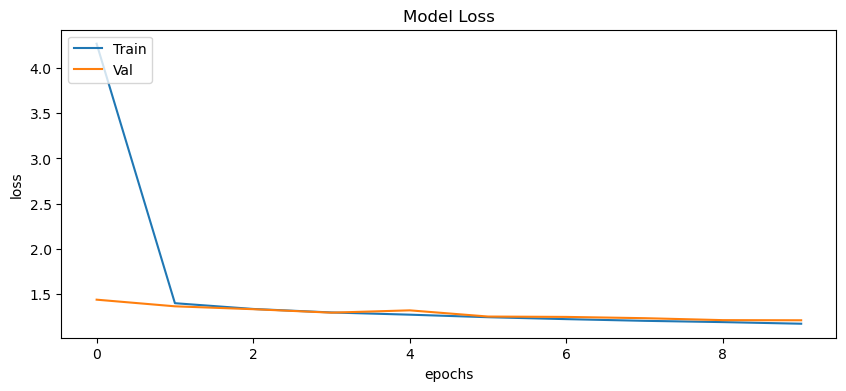

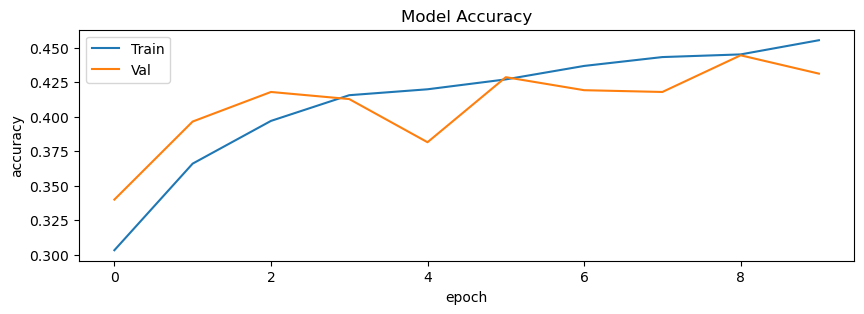

In [18]:
def visualize_loss_and_accuracy():
    # Plot the training and validation Loss
    plt.figure(figsize=(10,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['Train','Val'], loc= 'upper left')
    plt.show()

    # Plot the model accuracy
    plt.figure(figsize=(10,3))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

visualize_loss_and_accuracy()

As we see here, in the beginning, the validation accuracy is much higher than the training accuracy. Over time that merges into the opposite.
WHY?

We can see from the learning curves that the model is indeed underfitting. Both the training and validation accuracy curves plateau at a low value, indicating that the model is not learning the patterns in the data well enough.

### Make Prediction on the test dataset

In [12]:
testing_img_path = "./dataset/seg_test/seg_test/"


test_ds = keras.utils.image_dataset_from_directory(
    testing_img_path,
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

predictions = model.predict(test_ds)

# Get the predicted class for each image
predicted_classes = np.argmax(predictions, axis=1)

print('Predicted classes:', predicted_classes)
print('True labels:', val_ds.class_names)

Found 2499 files belonging to 5 classes.
Predicted classes: [3 3 3 ... 3 3 3]
True labels: ['buildings', 'forest', 'glacier', 'mountain', 'sea']


### Evaluate the performance of the model

In [30]:
accuracy = model.evaluate(test_ds)[1]
print(f'Accuracy: {accuracy}')

79/79 [==============================] - 1s 9ms/step - loss: 1.2455 - accuracy: 0.4082
Accuracy: 0.40816327929496765
